<div id="toc"></div>

In [7]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

last update: 2021/12/02   
created: : 2021/07/20

<!-- 
written with reference to :  
"exojax/examples/tutorial/Forward\ modeling.ipynb"  
"ghR/exojax_0/examples/testlines/line_strength_CO.py"  
-->

In [8]:
cd ~/work

/home/tako/work


In [48]:
%load_ext autoreload
%autoreload 2
#↑Reload the imported module each time running
from exojax.spec.rtransfer import nugrid
from exojax.spec.rtransfer import pressure_layer 
from exojax.spec import moldb, molinfo, contdb
from exojax.spec import atomll
from exojax.spec.exomol import gamma_exomol
from exojax.spec import SijT, doppler_sigma
from exojax.spec import planck
import jax.numpy as jnp
from jax import vmap, jit
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Set the path to save figures (optional)

In [10]:
#import pathlib
#path_fig = pathlib.Path('~/Dropbox/tmpfig')  #('/home/tako/work/fig')

## T-P profile 

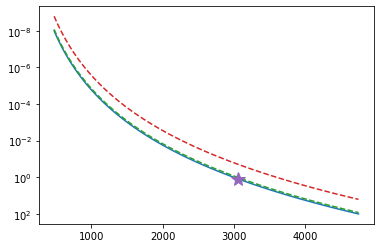

In [13]:
#Assume ATMOSPHERE                                                                     
NP=100
T0=3000. #10000. #3000. #1295.0 #K
Parr, dParr, k=pressure_layer(NP=NP)
H_He_HH_VMR = [0.0, 0.16, 0.84] #typical quasi-"solar-fraction"
Tarr = T0*(Parr)**0.1

PH = Parr* H_He_HH_VMR[0]
PHe = Parr* H_He_HH_VMR[1]
PHH = Parr* H_He_HH_VMR[2]

#roughly based on "p3200_g+5.0_m0.0_t01_st_z+0.00_a+0.00_c+0.00_n+0.00_o+0.00_r+0.00_s+0.00.mod" of MARCS model atmosphere  
#PH = 0.3 * Parr #H I
#PHH = 0.6 * Parr #H2
#PHe = 0.078 * Parr #He

import matplotlib.pyplot as plt

fig=plt.figure(figsize=(6,4))
plt.plot(Tarr,Parr)
plt.plot(Tarr, PH, '--'); plt.plot(Tarr, PHH, '--'); plt.plot(Tarr, PHe, '--')
plt.plot(Tarr[80],Parr[80], marker='*', markersize=15)
plt.yscale("log")
plt.gca().invert_yaxis()
plt.show()

## Wavenumber

In [14]:
#We set a wavenumber grid using nugrid.

nus,wav,res = nugrid(10380, 10450, 1000, unit="AA") 
#nus,wav,res = nugrid(10380, 10750, 5000, unit="AA")
#nus,wav,res=nugrid(22920,23000,1000,unit="AA")

xsmode assumes ESLOG: mode= lpf


## Load a database of atomic lines from VALD3

In [59]:
#Loading a database of a few atomic lines from VALD3  #BU: CO and CIA (H2-H2)... 

nus4LL = 1e8/np.array([1e5, 1500.])
valdlines = '/home/tako/work/VALD3/vald2600.gz'

adbFe=moldb.AdbVald('/home/tako/work/VALD3/HiroyukiIshikawa.4203812_test0724.ip', nus4LL, crit=1.e-100) #, crit=1.e-46)
#adbFe = moldb.AdbVald(valdlines, nus4LL)

Reading VALD file


In [17]:
#test211202
import copy 
adbFe_long = copy.deepcopy(adbFe)

In [22]:
#check
print(adbFe.ielem)
print(adbFe.atomicmass) #mass of each species
print(1.e8/adbFe.nu_lines)

[22 26 26 26 11]
[47.89999 55.847   55.847   55.847   22.98981]
[10399.6492 10398.6434 10381.8432 10749.3931 10749.3931]


## Relative partition function

In [61]:
#Computing the relative partition function,

qt_284=vmap(adbFe.QT_interp_284)(Tarr)
qt = np.zeros([len(adbFe.QTmask), len(Tarr)])
#qt = np.empty_like(adbFe.QTmask, dtype='object')
for i, mask in enumerate(adbFe.QTmask):
    qt[i] = qt_284[:,mask]  #e.g., qt_284[:,76] #Fe I
qt = jnp.array(qt)

print(qt.shape) #check

(5, 100)


## Pressure and Natural broadenings (Lorentzian width)  


In [64]:
gammaLMP = jit(vmap(atomll.gamma_vald3,(0,0,0,0,None,None,None,None,None,None,None,None,None,None,None)))\
        (Tarr, PH, PHH, PHe, adbFe.ielem, adbFe.iion, \
                adbFe.dev_nu_lines, adbFe.elower, adbFe.eupper, adbFe.atomicmass, adbFe.ionE, \
                adbFe.gamRad, adbFe.gamSta, adbFe.vdWdamp, 1.0)  

print(gammaLMP.shape) #check

(100, 5)


## Doppler broadening

In [65]:
from exojax.spec import doppler_sigma
print(adbFe.nu_lines.shape, Tarr.shape, adbFe.atomicmass.shape)#check
sigmaDM=jit(vmap(doppler_sigma,(None,0,None)))\
    (adbFe.nu_lines, Tarr, adbFe.atomicmass)

(5,) (100,) (5,)


## Line strength

In [67]:
from exojax.spec import SijT
SijM=jit(vmap(SijT,(0,None,None,None,0)))\
    (Tarr, adbFe.logsij0, adbFe.nu_lines, adbFe.elower, qt.T)

print(Tarr.shape, adbFe.logsij0.shape, adbFe.nu_lines.shape, adbFe.elower.shape, qt.T.shape, SijM.shape) #check

(100,) (5,) (5,) (5,) (100, 5) (100, 5)


In [68]:
#check
print(SijM.shape)
SijM[-5:,:] #five deepest atmospheric layers

(100, 5)


DeviceArray([[1.02835780e-17, 3.88288354e-21, 6.02294367e-22,
              3.19719976e-20, 2.04859096e-18],
             [1.05911767e-17, 4.36996690e-21, 6.79814277e-22,
              3.82951375e-20, 2.47857205e-18],
             [1.08921646e-17, 4.90149386e-21, 7.64660268e-22,
              4.56473159e-20, 2.98456608e-18],
             [1.11857318e-17, 5.47944471e-21, 8.57185802e-22,
              5.41538345e-20, 3.57716158e-18],
             [1.14711894e-17, 6.10563376e-21, 9.57725708e-22,
              6.39495141e-20, 4.26800091e-18]], dtype=float32)

## nu matrix

In [69]:
from exojax.spec import make_numatrix0
numatrix=make_numatrix0(nus, adbFe.nu_lines)

In [70]:
numatrix.shape

(5, 1000)

## Compute dtau for each atomic species (or ion) in a SEPARATE array

Separate species

In [72]:
def get_unique_list(seq):
    seen = []
    return [x for x in seq if x not in seen and not seen.append(x)]

uspecies = get_unique_list(jnp.vstack([adbFe.ielem, adbFe.iion]).T.tolist())

Set the stellar/planetary parameters

In [73]:
#Parameters of Objects
Rp = 0.36*10 #R_sun*10    #Rp=0.88 #[R_jup]
Mp = 0.37*1e3 #M_sun*1e3    #Mp=33.2 #[M_jup]
g = 2478.57730044555*Mp/Rp**2
print('logg: '+str(np.log10(g))) #check
#g=1.e5 #gravity cm/s2

logg: 4.849799190511717


Calculate delta tau

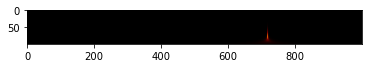

(100,) (100, 1000) (100,)
22 1 3.1272314e-06 47.89999


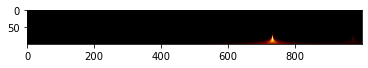

(100,) (100, 1000) (100,)
26 1 0.0012936727 55.847


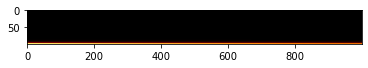

(100,) (100, 1000) (100,)
11 1 2.9265773e-05 22.98981


In [75]:
#For now, ASSUME all atoms exist as neutral atoms. 
#In fact, we can't ignore the effect of molecular formation e.g. TiO (」゜□゜)」

from exojax.spec.lpf import xsmatrix
from exojax.spec.rtransfer import dtauM

ieleml = jnp.array(adbFe.ipccd['ielem'])
Narr = jnp.array(10**(12+adbFe.ipccd['solarA'])) #number density
massarr = jnp.array(adbFe.ipccd['mass']) #mass of each neutral atom
Nmassarr = Narr * massarr #mass of each neutral species

dtaual = np.zeros([len(uspecies), len(Tarr), len(nus)])
maskl = np.zeros(len(uspecies)).tolist()
for i, sp in enumerate(uspecies):
    maskl[i] = (adbFe.ielem==sp[0])\
                    *(adbFe.iion==sp[1])
    
    #Currently not dealing with ionized species yet... (#tako %\\\\20210814)
    if sp[1] > 1:
        continue
     
    #Providing numatrix, thermal broadening, gamma, and line strength, we can compute cross section.  
    xsm=xsmatrix(numatrix[maskl[i]], sigmaDM.T[maskl[i]].T, gammaLMP.T[maskl[i]].T, SijM.T[maskl[i]].T)
        #xsmatrix has the shape of (# of layers, # of nu grid)
    ntmpf = 'tmp' + str(i) + '.pdf'
    fig=plt.figure(figsize=(6,1))
    plt.imshow(xsm, cmap="afmhot")#, aspect=5.)
    #plt.savefig(path_fig/ntmpf)
    plt.show() 
    
    #Computing delta tau for atomic absorption
    MMR_X_I = Nmassarr[ jnp.where(ieleml==sp[0])[0][0] ] / jnp.sum(Nmassarr)
    mass_X_I = massarr[ jnp.where(ieleml==sp[0])[0][0] ]
    #    ↑MMR and mass of neutral atom X (if all elemental species are neutral)
    dtaual[i] = dtauM(dParr, xsm, MMR_X_I*np.ones_like(Tarr), mass_X_I, g)

    #check
    print(dParr.shape, xsm.shape, (MMR_X_I*np.ones_like(Tarr)).shape)
    print(sp[0], sp[1], MMR_X_I, mass_X_I)

compute delta tau for CIA

In [76]:
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia', nus)

from exojax.spec.rtransfer import dtauCIA
mmw=2.33 #mean molecular weight
mmrH2=0.74
molmassH2=molinfo.molmass("H2")
vmrH2=(mmrH2*mmw/molmassH2) #VMR
dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,\
            mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)

H2-H2


## Total delta tau

In [77]:
dtau = np.sum(dtaual, axis=0) + dtaucH2H2

## Plot contribution function

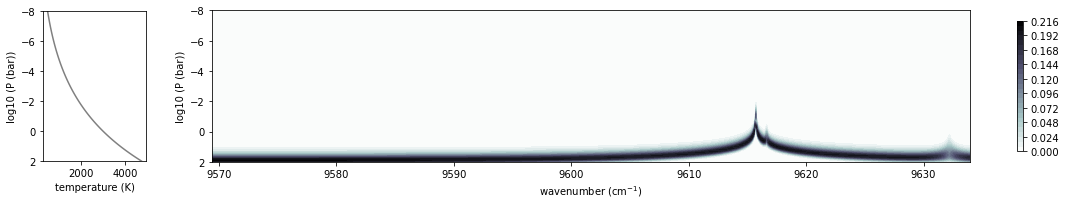

In [78]:
from exojax.plot.atmplot import plotcf
#fig=plt.figure(figsize=(3, 2))
plotcf(nus,dtau,Tarr,Parr,dParr)
plt.show()
#plt.savefig(path_fig/'contributionf_210814_test1.pdf') #tako

## Radiative transfer

In [79]:
from exojax.spec import planck
from exojax.spec.rtransfer import rtrun
sourcef = planck.piBarr(Tarr, nus)
F0=rtrun(dtau, sourcef)

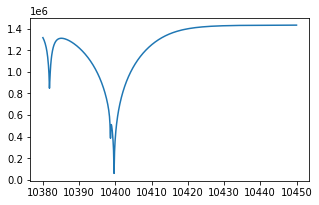

In [80]:
fig=plt.figure(figsize=(5, 3))
plt.plot(wav[::-1],F0)
plt.show()
#plt.savefig(path_fig/'flux_210814_test2.pdf') #tako

In [81]:
#Check line wavelength
print(adbFe.ielem)
print(1.e8/adbFe.nu_lines)

[22 26 26 26 11]
[10399.6492 10398.6434 10381.8432 10749.3931 10749.3931]


## Rotational & instrumental broadening

In [82]:
from exojax.spec import response
from exojax.utils.constants import c #[km/s]
import jax.numpy as jnp

wavd=jnp.linspace(10380, 10450,500) #observational wavelength grid
nusd = 1.e8/wavd[::-1]

RV=10.0 #RV km/s
vsini=20.0 #Vsini km/s
u1=0.0 #limb darkening u1
u2=0.0 #limb darkening u2

R=100000.
beta=c/(2.0*np.sqrt(2.0*np.log(2.0))*R) #IP sigma need check 

Frot=response.rigidrot(nus,F0,vsini,u1,u2)
F=response.ipgauss_sampling(nusd,nus,Frot,beta,RV)

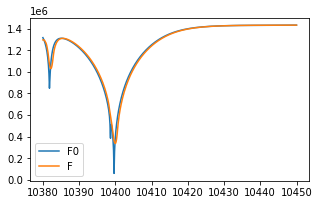

In [83]:
fig=plt.figure(figsize=(5, 3))
plt.plot(wav[::-1],F0, label='F0')
plt.plot(wavd[::-1],F, label='F')
plt.legend()
plt.show()
#plt.savefig(path_fig/'flux+rot_210814_test3_dtaual.pdf') #tako